In [146]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import os
import pysam
import pyranges as pr
import rapidfuzz

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, Normalize

sys.path.append("../")
import utils as ut

In [2]:
# load the GTF
gtf_path = "/scratch/indikar_root/indikar1/cstansbu/HSC/references/annotations.gtf"
gf = pr.read_gtf(gtf_path)
gdf = gf.df
print(f"{gdf.shape=}")
print(gdf.columns)
gdf.head()

gdf.shape=(3371244, 26)
Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'transcript_id', 'transcript_version',
       'transcript_name', 'transcript_source', 'transcript_biotype', 'tag',
       'ccds_id', 'exon_number', 'exon_id', 'exon_version', 'protein_id',
       'protein_version', 'transcript_support_level'],
      dtype='object')


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_version,...,transcript_source,transcript_biotype,tag,ccds_id,exon_number,exon_id,exon_version,protein_id,protein_version,transcript_support_level
0,1,ensembl_havana,gene,1471764,1497848,.,+,.,ENSG00000160072,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ensembl_havana,transcript,1471764,1497848,.,+,.,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,NaN,NaN,NaN,NaN,NaN,NaN
2,1,ensembl_havana,exon,1471764,1472089,.,+,.,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1,ENSE00003889014,1,NaN,NaN,NaN
3,1,ensembl_havana,CDS,1471884,1472089,.,+,0,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1,NaN,NaN,ENSP00000500094,1,NaN
4,1,ensembl_havana,start_codon,1471884,1471887,.,+,0,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1,NaN,NaN,NaN,NaN,NaN


In [3]:
# get the gtf records we care about
TFs = [
    'GATA2', 
    'GFI1B', 
    'FOS', 
    'STAT5A',
    'REL',  
]
print(f"{len(TFs)=}")

genes = gdf.copy()
genes = gdf[gdf['Feature'].isin(['gene'])]
genes = genes[genes['gene_name'].isin(TFs)]

genes = genes.groupby(['gene_name', 'Feature']).agg(
    Chromosome = ('Chromosome', 'first'),
    Strand = ('Strand', 'first'),
    Start = ('Start', 'min'),
    End = ('End', 'max'),
).reset_index(drop=False)


genes['Length'] = genes['End'] - genes['Start']

genes

len(TFs)=5


,gene_name,Feature,Chromosome,Strand,Start,End,Length
0,FOS,gene,14,+,75278825,75282230,3405
1,GATA2,gene,3,-,128479426,128493201,13775
2,GFI1B,gene,9,+,132943999,132991687,47688
3,REL,gene,2,+,60881490,60931612,50122
4,STAT5A,gene,17,+,42287546,42311943,24397


# get all TF reads

In [20]:
bam_path = "/scratch/indikar_root/indikar1/cstansbu/HSC/merged/merged.bam"
buffer_bp = 1000 # base pair fudge factor
res = []

bamfile = pysam.AlignmentFile(bam_path, "rb")

for _, gene_rec in genes.iterrows():
    chrom = gene_rec['Chromosome']
    start = gene_rec['Start'] - buffer_bp
    end = gene_rec['End'] + buffer_bp
    
    for read in bamfile.fetch(chrom, start, end):
        barcode = read.qname.split('_')[0]
        umi = read.qname.split('_')[1].split("#")[0]
        read_name = read.qname.split("#")[1][:-2]

        if not read.is_secondary:
        
            row = {
                'barcode' : barcode,
                'umi' : umi,
                'read_name' : read_name,
                'forward' : read.is_forward,
                'mapping_quality' : read.mapping_quality,
                'gene_name' : gene_rec['gene_name'],
                'query_length' : read.query_length,
                'query_name' : read.query_name,
            }
            res.append(row)
        
res = pd.DataFrame(res)
print(f"{res.shape=}")
res

res.shape=(40310, 8)


,barcode,umi,read_name,forward,mapping_quality,gene_name,query_length,query_name
0,TTACTGTCATTAAGCC,ATCATACTGATA,176f6512-be8e-4cb7-a6d8-0ce381b7b43b,False,60,FOS,924,TTACTGTCATTAAGCC_ATCATACTGATA#176f6512-be8e-4c...
1,TGTGAGTAGGCATTTC,AACATTCGAAGG,8080a116-4412-4da0-bee5-12da276833f3,True,60,FOS,1386,TGTGAGTAGGCATTTC_AACATTCGAAGG#8080a116-4412-4d...
2,CCGTGAGCAAATCCCA,CACGCACTAAAC,c2615c99-8cf3-4cce-bc92-4e1a0c35e81d,True,60,FOS,368,CCGTGAGCAAATCCCA_CACGCACTAAAC#c2615c99-8cf3-4c...
3,CTCACTGCAAATGGAT,CTTTTGTAGGTG,62202ae9-09a6-436b-9ad5-5c4e4a9da6d8,True,38,FOS,802,CTCACTGCAAATGGAT_CTTTTGTAGGTG#62202ae9-09a6-43...
4,GGTGGCTTCCATCTGC,TTGTATGTACAA,65280854-46e4-4a12-a654-f1aac405d480,False,19,FOS,196,GGTGGCTTCCATCTGC_TTGTATGTACAA#65280854-46e4-4a...
...,...,...,...,...,...,...,...,...
40305,ATGGGTTTCGTCTCAC,CTTGCTAAGTCT,d9b1465b-d1ba-4e59-97a8-9a45249bd5db,True,60,STAT5A,655,ATGGGTTTCGTCTCAC_CTTGCTAAGTCT#d9b1465b-d1ba-4e...
40306,CACCAAATCCGTAGGC,CTTTTACTTCCA,c3ca5e5b-485a-4875-bb74-8a22a2b3016a,False,60,STAT5A,646,CACCAAATCCGTAGGC_CTTTTACTTCCA#c3ca5e5b-485a-48...
40307,GAAGCGAAGCAGGCTA,TTGGGATGCAGG,b48ecefd-1077-43df-b447-382a4c3ba431,True,60,STAT5A,670,GAAGCGAAGCAGGCTA_TTGGGATGCAGG#b48ecefd-1077-43...
40308,ATGCATGTCCATCTCG,TCCTCTGCGTCT,fb968168-d64b-4103-a757-c4ddf13f53d4,True,60,STAT5A,626,ATGCATGTCCATCTCG_TCCTCTGCGTCT#fb968168-d64b-41...


In [21]:
res['gene_name'].value_counts()

gene_name
FOS       21378
REL       12882
GATA2      4841
STAT5A     1023
GFI1B       186
Name: count, dtype: int64

In [22]:
# build the read mapper
qnames = res.copy()
qnames = qnames.drop_duplicates(subset='query_name')
qnames = qnames.set_index('query_name')

read_mapper = qnames.to_dict(orient='index')
qnames['gene_name'].value_counts()

gene_name
FOS       21329
REL       12817
GATA2      4755
STAT5A     1015
GFI1B       186
Name: count, dtype: int64

# query the fastq files

In [25]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/v5_tagged/v5_tagged.fastq.gz"

# tag sequences
v5_tags = {
    'V5' : "AGTGGGTTTGGGATTGGCTTTCC", 
    'V5rc' : "GGAAAGCCAATCCCAAACCCACT",
    'HT' : "GTGGTGGTGGTGGTGGTG",
    'HTrc' : "CACCACCACCACCACCAC",
}

res = []
fastq = pysam.FastxFile(fpath)

for read in fastq:
    gene_name = read_mapper[read.name]['gene_name']
    barcode = read_mapper[read.name]['barcode']
    umi = read_mapper[read.name]['umi']

    read_seq = read.sequence

    
    row = {
        'barcode' : barcode,
        'umi' : umi,
        'gene_name' : gene_name,
        'read_len' : len(read_seq),
    }

    for tag, tag_seq in v5_tags.items():
        row[tag] = tag_seq in read_seq
    
    res.append(row)
    
res = pd.DataFrame(res)
print(f"{res.shape=}")
res.head()

res.shape=(40102, 8)


,barcode,umi,gene_name,read_len,V5,V5rc,HT,HTrc
0,CCCATTGCAAGACTGG,AAAAGATTGCAC,FOS,559,False,False,False,False
1,CGGCAGTGTTGACTAC,TGGCTAAGTCGT,REL,442,False,False,False,False
2,AGGTCATGTGGTCTCG,CATGCGGACGCT,REL,487,False,False,False,False
3,TAGCACATCTTGGTGA,ACCTTCTGATAT,FOS,451,False,False,False,False
4,TTCCGTGTCGAATGCT,CTGAACAGCTTT,REL,503,False,False,False,False


In [27]:
for v5 in ['V5', 'V5rc']:
    for ht in ['HT', 'HTrc']:
        n = res[res[v5] & res[ht]].shape[0]
        print(f"{v5} {ht} {n=}")

V5 HT n=44
V5 HTrc n=0
V5rc HT n=0
V5rc HTrc n=98


In [70]:
gx = res.copy()
gx = gx.drop_duplicates(subset=['barcode', 'gene_name',])

# flag the v5 tags
gx['flag'] = gx[['V5', 'V5rc', 'HT', 'HTrc']].sum(axis=1)

gx = pd.pivot_table(gx, index='barcode',
                    columns='gene_name',
                    values='flag')

gx = gx.fillna(0)
print(gx.columns)
gx['n_flags'] = gx.sum(axis=1)
gx['has_flag'] = gx['n_flags'].astype(bool)
gx = gx.sort_values(by='n_flags', ascending=False)

print(gx.sum(axis=0))
print(f"{gx.shape=}")
gx.head()

Index(['FOS', 'GATA2', 'GFI1B', 'REL', 'STAT5A'], dtype='object', name='gene_name')
gene_name
FOS          41.0
GATA2       135.0
GFI1B         0.0
REL           4.0
STAT5A        2.0
n_flags     182.0
has_flag    124.0
dtype: float64
gx.shape=(6989, 7)


gene_name,FOS,GATA2,GFI1B,REL,STAT5A,n_flags,has_flag
barcode,,,,,,,
GCTACAAGTATACCTG,0.0,2.0,0.0,0.0,0.0,2.0,True
CGCCATTCACACGGTC,2.0,0.0,0.0,0.0,0.0,2.0,True
GGAACCCTCGCAGTCG,0.0,2.0,0.0,0.0,0.0,2.0,True
GTCTAGAGTTGCTCAA,2.0,0.0,0.0,0.0,0.0,2.0,True
TACGGGCCAAATACAG,0.0,2.0,0.0,0.0,0.0,2.0,True


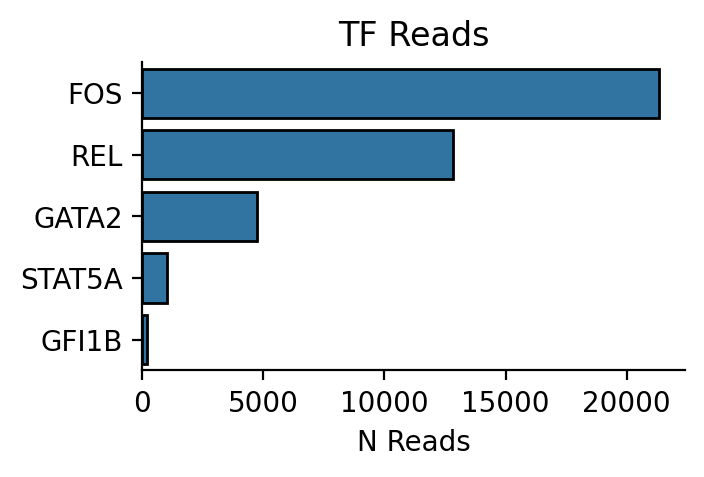

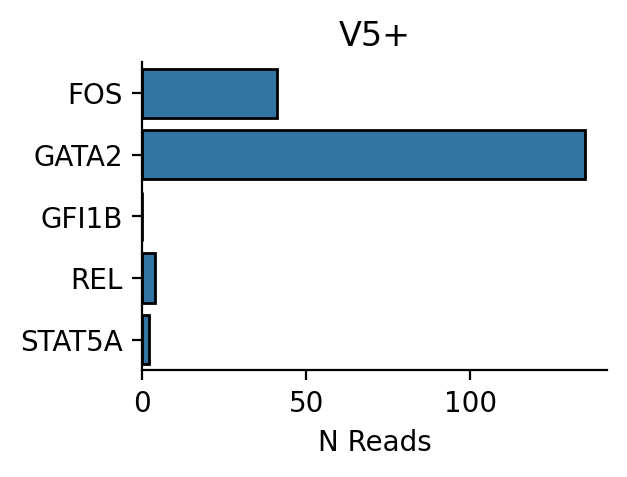

In [92]:
tf_list = [
    'FOS', 
    'GATA2', 
    'GFI1B', 
    'REL',
    'STAT5A',
]

all_reads = qnames['gene_name'].value_counts()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2
sns.barplot(data=all_reads,
            ec='k',
            orient='h')

plt.title('TF Reads')   
plt.xlabel('N Reads')               
plt.ylabel('')               
sns.despine()
plt.show()


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2
sns.barplot(data=gx[tf_list].sum(axis=0),
            ec='k',
            orient='h')

plt.title('V5+')   
plt.xlabel('N Reads')               
plt.ylabel('')               
sns.despine()
plt.show()

# load single-cell data

In [58]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.clustered.h5ad"

adata = sc.read_h5ad(fpath)
adata.obs['cluster_name'] = adata.obs['clusters'].apply(lambda x: f"C{int(x) + 1}")
adata

AnnData object with n_obs × n_vars = 8484 × 14936
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'clusters_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [59]:
# merge V5 tags

"""drop barcodes not present in the single-cell data """
gx = gx[gx.index.isin(adata.obs.index)]
print(f"{gx.shape=}")


adata.obs = pd.merge(adata.obs, gx, 
                     how='left',
                     left_index=True,
                     right_index=True,)

adata

gx.shape=(6969, 7)


AnnData object with n_obs × n_vars = 8484 × 14936
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2', 'FOS', 'GATA2', 'GFI1B', 'REL', 'STAT5A', 'n_flags', 'has_flag'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'clusters_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

has_flag
False    6845
True      124
Name: count, dtype: int64


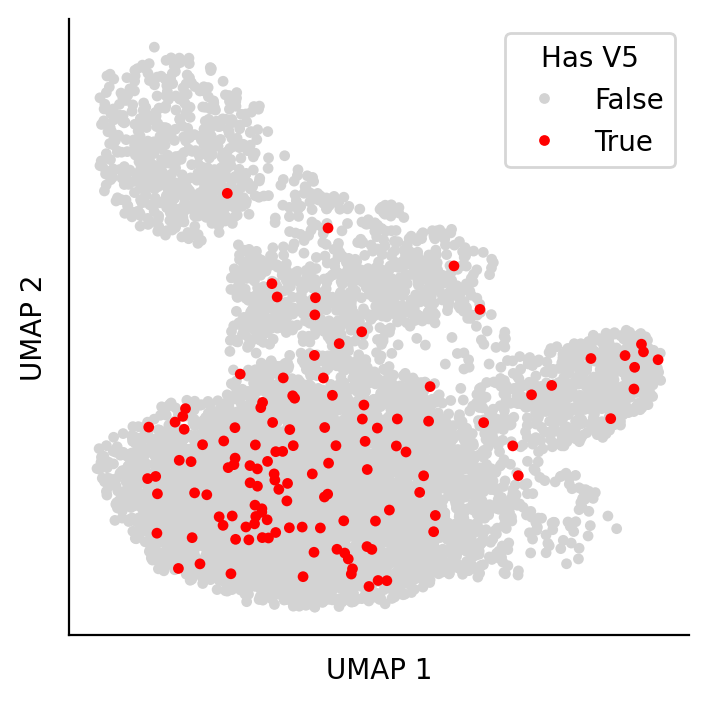

In [98]:
pdf = adata.obs.copy()
pdf = pdf.sort_values(by='has_flag', 
                      ascending=True)

print(pdf['has_flag'].value_counts())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sns.scatterplot(data=pdf,
                x='UMAP 1',
                y='UMAP 2',
                s=15,
                ec='none',
                palette=['lightgrey', 'r'],
                hue='has_flag')

_ = plt.yticks([])
_ = plt.xticks([])

sns.move_legend(plt.gca(), 
                title='Has V5',
                loc='upper right')
sns.despine()

,cluster_name,has_flag,count
0,C1,False,4958
1,C3,False,760
2,C2,False,591
3,C4,False,536
4,C1,True,104
5,C4,True,10
6,C3,True,9
7,C2,True,1


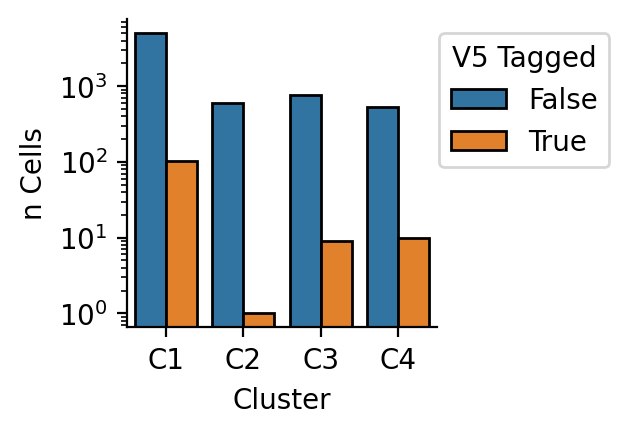

In [114]:
pdf = adata.obs.copy()

pdf = pdf[['cluster_name', 'has_flag']].value_counts().reset_index(drop=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2

sns.barplot(data=pdf, 
            x='cluster_name',
            y='count',
            hue='has_flag',
            ec='k')

plt.yscale('log')
plt.ylabel('n Cells')
plt.xlabel('Cluster')
sns.move_legend(plt.gca(),
                 loc='upper right',
                 title='V5 Tagged',
                bbox_to_anchor=(1.6, 1),
               )
sns.despine()
pdf

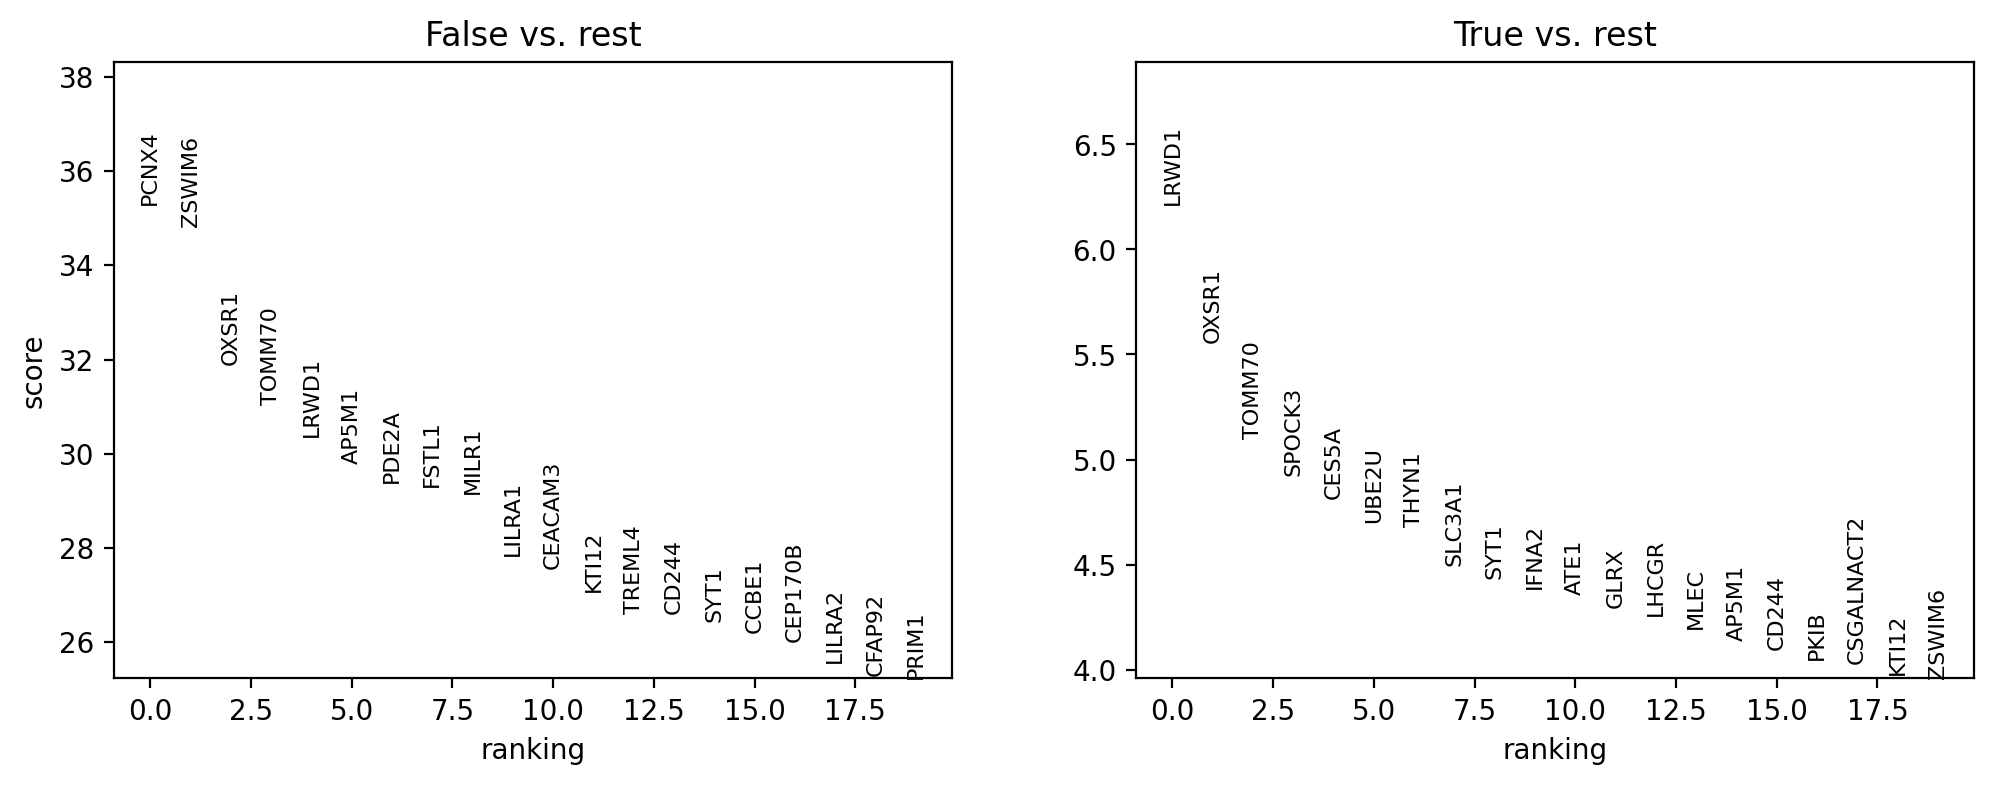

,group,names,scores,logfoldchanges,pvals,pvals_adj,gene_name
0,False,ENSG00000126773,35.287617,6.591179,9.094939e-273,1.358420e-268,PCNX4
1,False,ENSG00000130449,34.821793,4.280805,1.138386e-265,8.501468e-262,ZSWIM6
2,False,ENSG00000172939,31.882025,3.518256,4.739406e-223,2.359592e-219,OXSR1
3,False,ENSG00000154174,31.039227,4.262247,1.594493e-211,5.953835e-208,TOMM70
4,False,ENSG00000161036,30.352371,4.268227,2.337845e-202,6.983609e-199,LRWD1


In [117]:
# are there expression differences between the two groups?
adata.obs['flag_cat'] = adata.obs['has_flag'].astype('category')

sc.tl.rank_genes_groups(adata, 
                        'flag_cat', 
                        method='wilcoxon')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        sharey=False, 
                        gene_symbols='gene_name')

deg = sc.get.rank_genes_groups_df(adata, 
                                  gene_symbols='gene_name',
                                  group=None)

deg.head()

In [125]:
alpha = 0.01

sig = deg[deg['pvals_adj'] <= alpha].reset_index(drop=True)
sig['is_TF'] = sig['gene_name'].isin(tf_list)

for group_name, group in sig.groupby('group'):
    group = group.sort_values(by='logfoldchanges', ascending=False)

    tf_deg = group[group['is_TF']]
    print(tf_deg)
    break


      group            names    scores  logfoldchanges     pvals  pvals_adj  \
3221  False  ENSG00000179348  3.528791        0.760679  0.000417   0.001759   

     gene_name  is_TF  
3221     GATA2   True  


/tmp/ipykernel_3896424/1865016832.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf,


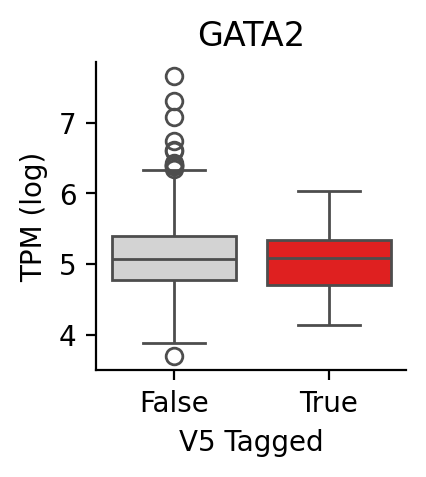

In [163]:
def plot_expression(adata, gene, drop_zero=True):
    gene_id = adata.var[adata.var['gene_name'] == gene].index[0]
    pdf = adata.obs.copy()
    pdf['gene'] = adata[:, [gene_id]].to_df()
    
    if drop_zero:
        pdf = pdf[pdf['gene'] > 0]

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 2, 2
    sns.boxplot(data=pdf, 
                 x='has_flag',
                 y='gene',
                 palette=['lightgrey', 'r'])
    
    plt.xlabel("V5 Tagged")
    plt.ylabel("TPM (log)")
    plt.title(gene)
    
    sns.despine()
    plt.show()
    

gene = 'GATA2'
plot_expression(adata, gene, drop_zero=True)

In [147]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
celltypes = [
    'Hematopoietic stem cells',
    'Fibroblasts',
]
cell_names = [
    'Fib',
    'HSC'
]
markers = ut.get_marker_genes(fpath, adata, celltypes, cell_names)
markers.head()

,gene_name,Chromosome,Start,End,Strand,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,Fib,HSC
gene_id,,,,,,,,,,,,,,,,,
ENSG00000028137,TNFRSF1B,1,12166990,12209228,+,1784,False,1784,0.253065,78.972183,2147,True,3.829290,5.791682,0.990715,1.0,0.0
ENSG00000116132,PRRX1,1,170662727,170739421,+,52,False,52,0.006129,99.387082,52,False,0.686794,5.337635,-0.561626,1.0,0.0
ENSG00000150681,RGS18,1,192158461,192185815,+,515,False,515,0.073904,93.929750,627,False,2.531405,5.449209,-0.428357,0.0,1.0
ENSG00000092969,TGFB2,1,218345335,218444619,+,54,False,54,0.006365,99.363508,54,False,0.687895,5.194011,-0.973616,0.0,1.0
ENSG00000116690,PRG4,1,186296278,186314567,+,250,False,250,0.030882,97.053277,262,False,1.838942,5.414113,-0.519322,1.0,0.0


# Fib/HCS markers in V5- cells

In [183]:
alpha = 0.01
celltype = 'Fib'

sig = deg[deg['pvals_adj'] <= alpha].reset_index(drop=True)
sig['is_marker'] = sig['gene_name'].isin(markers[markers[celltype] == 1]['gene_name'].values)

sig = sig[sig['is_marker']]
sig = sig.sort_values(by='logfoldchanges', ascending=False)
print(f"{sig.shape=}")

print(sig['group'].value_counts())

sig.head()

sig.shape=(47, 8)
group
False    47
True      0
Name: count, dtype: int64


,group,names,scores,logfoldchanges,pvals,pvals_adj,gene_name,is_marker
7,False,ENSG00000163430,29.289927,4.345322,1.393581e-188,2.601816e-185,FSTL1,True
12,False,ENSG00000188056,26.613617,3.821301,4.722523e-156,4.408475e-153,TREML4,True
65,False,ENSG00000196352,17.579449,2.711173,3.540067e-69,5.874938e-67,CD55,True
3405,False,ENSG00000100644,3.415398,1.845523,6.368895e-04,2.548240e-03,HIF1A,True
520,False,ENSG00000149968,8.222007,1.743100,2.001260e-16,4.577460e-15,MMP3,True


/tmp/ipykernel_3896424/1865016832.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf,


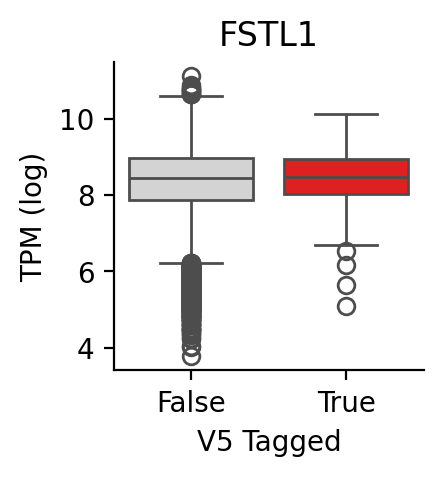

/tmp/ipykernel_3896424/1865016832.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf,


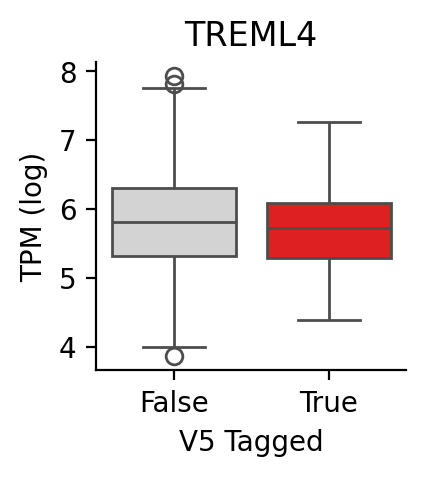

/tmp/ipykernel_3896424/1865016832.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf,


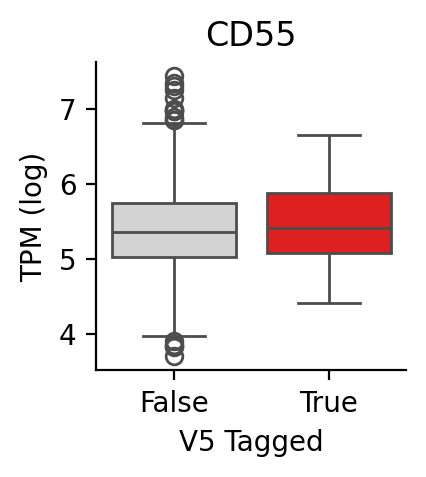

In [172]:
n_plot = 3

for idx, row in sig.head(n_plot).iterrows():
    gene = row['gene_name']
    plot_expression(adata, gene, drop_zero=True)
    

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# archive

In [ ]:
break

In [ ]:
for col in ['barcode', 'umi', 'read_name']:
    print(f"\n==== {col.upper()} SUMMARY ====")
    total = res[col].count()
    print(f"Total: {total}")
    print(f"Unique: {res[col].nunique()} ({res[col].nunique() / total:.3f})")
    print()
    gx = res.groupby('gene_name').agg(
        total = (col, 'count'),
        unique = (col, 'nunique'),
    ).reset_index()
    gx['percent'] = gx['unique'] / gx['total']
    gx['percent'] = gx['percent'].round(3)

    print(gx.to_string(index=False))

# Summary of reads mapped to the 5 TFs

In [ ]:
gx = res.groupby('gene_name').agg(
    unique_barcodes = ('barcode', 'nunique'),
    unique_umi = ('umi', 'nunique'),
    unique_reads = ('read_name', 'nunique'),
).reset_index(drop=False)

for col in ['unique_barcodes', 'unique_umi', 'unique_reads']:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 3.2, 2
    sns.barplot(data=gx, 
                x='gene_name', 
                y=col,
                # hue='forward',
                ec='k')

    # sns.move_legend(plt.gca(), 
    #                 title='Mapped Forward',
    #                 loc='upper right',
    #                 bbox_to_anchor=(1.1, 1.5))
    plt.xlabel('')
    sns.despine()
    plt.show()

In [ ]:
sns.histplot(data=res, 
             x='mapping_quality', 
             multiple='stack',
             bins=31)

plt.xlabel("Mapping Quality")
sns.despine()

plt.yscale('log')

# barcode summary

In [ ]:
gx = res.groupby(['barcode', 'gene_name']).agg(
    unique_umi = ('umi', 'nunique'),
).reset_index(drop=False)

gx = pd.pivot_table(gx, index='barcode',
                    columns='gene_name',
                    values='unique_umi')
gx = gx.fillna(0)
gx = gx.astype(bool)
columns = list(gx.columns)
gx = gx.reset_index(drop=False)

mat = gx.groupby(columns)['barcode'].count().reset_index(drop=False)
print(f"{mat.shape=}")
mat = mat.sort_values(by='barcode', ascending=False)
mat = mat.rename(columns={'barcode' : 'N Cells'})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 7

sns.heatmap(mat[columns].astype(int),
            cbar=False,
            annot=True,
            lw=0.5,
            linecolor='k',
            cmap=['w', 'blue'])

ax = plt.gca()
ax.set_yticks([])

divider = make_axes_locatable(ax) 
ax2 = divider.append_axes(position='right', size="35%", pad="7%")

sns.heatmap(mat[['N Cells']],
            cbar=False,
            lw=0.3,
            linecolor='k',
            cmap='viridis',
            fmt=".0f",
            annot=True,
            norm=LogNorm(),
            ax=ax2)

ax2.set_xlabel('')
ax2.set_yticks([])
sns.despine(right=False, 
            bottom=False, 
            left=False,
            top=False)

# write TF reads to file

In [ ]:
bam_path = "/scratch/indikar_root/indikar1/cstansbu/HSC/merged/merged.bam"
outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/10xBarcoded_SingleCell/all_merged/v5_reads/tf_read_ids.txt"
buffer_bp = 1000 # base pair fudge factor

bamfile = pysam.AlignmentFile(bam_path, "rb")

qnames = []
for _, gene_rec in genes.iterrows():
    chrom = gene_rec['Chromosome']
    start = gene_rec['Start'] - buffer_bp
    end = gene_rec['End'] + buffer_bp
    
    for read in bamfile.fetch(chrom, start, end):
        query_name = read.query_name
        
        row = {
            'query_name' : query_name,
        }
        qnames.append(row)
        
qnames = pd.DataFrame(qnames)
qnames.to_csv(outpath, index=False, header=False,)
qnames.head()

# After extracting reads based on V5 sequence or reads from the above alignments

`seqkit -sp "AGTGGGTTTGGGATTGGCTTTCC, GGAAAGCCAATCCCAAACCCACT" -m 1 -j 36 -o [output] [input] `

and

`seqkit -n -f tf_read_ids.txt -j 36 -o [output] [input] `

results stored in: `/nfs/turbo/umms-indikar/shared/projects/HSC/data/10xBarcoded_SingleCell/all_merged/v5_reads/`

In [ ]:
# break

# ID V5 tags 

In [ ]:
bam_path = "/scratch/indikar_root/indikar1/cstansbu/HSC/merged/merged.bam"
buffer_bp = 1000 # base pair fudge factor

# tag sequences
v5_tags = {
    'V5' : "AGTGGGTTTGGGATTGGCTTTCC", 
    'V5rc' : "GGAAAGCCAATCCCAAACCCACT",
    'HT' : "GTGGTGGTGGTGGTGGTG",
    'HTrc' : "CACCACCACCACCACCAC",
}


bamfile = pysam.AlignmentFile(bam_path, "rb")
res = []
for _, gene_rec in genes.iterrows():
    chrom = gene_rec['Chromosome']
    start = gene_rec['Start'] - buffer_bp
    end = gene_rec['End'] + buffer_bp
    
    for read in bamfile.fetch(chrom, start, end):
        barcode = read.qname.split('_')[0]
        umi = read.qname.split('_')[1].split("#")[0]
        read_name = read.qname.split("#")[1][:-2]
        
        row = {
            'barcode' : barcode,
            'umi' : umi,
            'read_name' : read_name,
            'forward' : read.is_forward,
            'mapping_quality' : read.mapping_quality,
            'gene_name' : gene_rec['gene_name'],
            'query_length' : read.query_length,
        }

        # search for tag in query seq
        # query_seq = read.seq
        query_seq = read.get_forward_sequence()
        # print(query_seq)
    #     break
    # break

        for tag, tag_seq in v5_tags.items():
            row[tag] = tag_seq in query_seq
        
        res.append(row)
        
res = pd.DataFrame(res)
res.head()

In [ ]:
for tag, _ in v5_tags.items():
    print(f"\n==== {tag.upper()} SUMMARY ====")

    print(res[tag].value_counts())

In [ ]:
for v5 in ['V5', 'V5rc']:
    for ht in ['HT', 'HTrc']:
        n = res[res[v5] & res[ht]].shape[0]
        print(f"{v5} {ht} {n=}")

In [ ]:
gx = res.copy()
gx['has_tag'] = (gx['V5'] & gx['HT']) | (gx['V5rc'] & gx['HTrc'])

print(gx.groupby(['has_tag',])['barcode'].nunique())

groupers = ['gene_name', 'has_tag']
gx = gx.groupby(groupers)['barcode'].nunique().reset_index()

gx = pd.pivot_table(gx, 
                    index='gene_name',
                    columns='has_tag',
                    values='barcode')
gx = gx.fillna(0)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3
sns.heatmap(gx,
            annot=True,
            lw=1,
            linecolor='k',
            cbar=False,
            fmt=".0f",
            cmap=['w'])

plt.ylabel("")
plt.xlabel("Has V5 Tag")
plt.gca().tick_params(axis='y', rotation=0)
sns.despine(right=False, 
            bottom=False, 
            left=False,
            top=False)

In [ ]:
break

# Check FASTQ files

check the fastq files for V5 tags

In [ ]:
# bam_path = "/scratch/indikar_root/indikar1/cstansbu/HSC/merged/merged.bam"
# buffer_bp = 1000 # base pair fudge factor

# bamfile = pysam.AlignmentFile(bam_path, "rb")

# qnames = []
# for _, gene_rec in genes.iterrows():
#     chrom = gene_rec['Chromosome']
#     start = gene_rec['Start'] - buffer_bp
#     end = gene_rec['End'] + buffer_bp
    
#     for read in bamfile.fetch(chrom, start, end):
#         query_name = read.query_name
#         barcode = read.qname.split('_')[0]
#         umi = read.qname.split('_')[1].split("#")[0]
#         read_name = read.qname.split("#")[1][:-2]
        
#         row = {
#             'read_name' : query_name,
#             'gene_name' : gene_rec['gene_name'],
#             'barcode' : barcode,
#             'umi' : umi,
#         }
#         qnames.append(row)
        
# qnames = pd.DataFrame(qnames)
# qnames = qnames.drop_duplicates()
# qnames = qnames.set_index('read_name')
# read_mapper = qnames.to_dict(orient='index')
# qnames.head()

In [ ]:
# fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/10xBarcoded_SingleCell/all_merged/v5_reads/matched_ids.fastq"

# res = []


# fastq = pysam.FastxFile(fpath)

# for read in fastq:
#     gene_name = read_mapper[read.name]['gene_name']
#     barcode = read_mapper[read.name]['barcode']
#     umi = read_mapper[read.name]['umi']

#     read_seq = read.sequence
    
#     row = {
#         'barcode' : barcode,
#         'umi' : umi,
#         'gene_name' : gene_name,
#         'read_len' : len(read_seq),
#     }

#     for tag, tag_seq in v5_tags.items():
#         row[tag] = tag_seq in read_seq
        
#     res.append(row)
    
# res = pd.DataFrame(res)
# res.head()

In [ ]:
# for tag, _ in v5_tags.items():
#     print(f"\n==== {tag.upper()} SUMMARY ====")

#     print(res[tag].value_counts())

In [ ]:
# for v5 in ['V5', 'V5rc']:
#     for ht in ['HT', 'HTrc']:
#         n = res[res[v5] & res[ht]].shape[0]
#         print(f"{v5} {ht} {n=}")

In [ ]:
# gx = res.copy()
# gx['has_tag'] = (gx['V5'] & gx['HTrc']) | (gx['V5rc'] & gx['HT'])

# print(gx.groupby(['has_tag',])['barcode'].nunique())

# groupers = ['gene_name', 'has_tag']
# gx = gx.groupby(groupers)['barcode'].nunique().reset_index()

# gx = pd.pivot_table(gx, 
#                     index='gene_name',
#                     columns='has_tag',
#                     values='barcode')
# gx = gx.fillna(0)
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 2, 3
# sns.heatmap(gx,
#             annot=True,
#             lw=1,
#             linecolor='k',
#             cbar=False,
#             fmt=".0f",
#             cmap=['w'])

# plt.ylabel("")
# plt.xlabel("Has V5 Tag")
# plt.gca().tick_params(axis='y', rotation=0)
# sns.despine(right=False, 
#             bottom=False, 
#             left=False,
#             top=False)

# Load single-cell data

In [ ]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.clustered.h5ad"

adata = sc.read_h5ad(fpath)
adata.obs['cluster_name'] = adata.obs['clusters'].apply(lambda x: f"C{int(x) + 1}")
adata

# merge V5 positive reads

In [ ]:
""" Load the single cell data"""
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.clustered.h5ad"
adata = sc.read_h5ad(fpath)
adata.obs['cluster_name'] = adata.obs['clusters'].apply(lambda x: f"C{int(x) + 1}")


"""Structure the v5 tag results """
gx = res.copy()
gx['has_tag'] = (gx['V5'] & gx['HT']) | (gx['V5rc'] & gx['HTrc'])
gx = gx[gx['has_tag']]
print(f"{gx.shape=}")

gx = gx[['barcode', 'gene_name']].drop_duplicates()
gx['val'] = True
gx = pd.pivot_table(gx, 
                    index='barcode', 
                    columns='gene_name',
                    values='val')

gx = gx.fillna(0)
v5_columns = [f"{x}_v5" for x in gx.columns]
gx.columns = v5_columns

"""Lastly, drop barcodes not present in the single-cell data """
gx = gx[gx.index.isin(adata.obs.index)]
print(f"{gx.shape=}")

"""merge """
adata.obs = pd.merge(adata.obs, gx, 
                     how='left',
                     left_index=True,
                     right_index=True)

adata.obs[v5_columns] = adata.obs[v5_columns].fillna(0)

adata.obs['has_tag'] = adata.obs[v5_columns].astype(bool).sum(axis=1)

print()
print(adata.obs['has_tag'].value_counts())

print()
adata

In [ ]:
""" Plot it """
pdf = adata.obs.copy()
order = np.argsort(pdf['has_tag'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=pdf.iloc[order], 
                x='UMAP 1',
                y='UMAP 2',
                hue='has_tag',
                ec='k',
                # palette=['lightgrey', 'r'],
                s=10)

plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
sns.despine()

sns.move_legend(plt.gca(),
                loc='upper right',
                title="V5+")

In [ ]:
pdf = adata.obs.copy()

# filter just the positive cells
pdf = pdf[pdf['has_tag'] == 1]
print(f"{pdf.shape=}")

pdf

In [ ]:
break

In [ ]:
pos = adata[adata.obs['has_tag'] == 1]
neg = adata[adata.obs['has_tag'] == 0]

pos_df = pos.to_df(layer='counts')
neg_df = neg.to_df(layer='counts')
pos_df.columns = pos.var['gene_name'].to_list()
neg_df.columns = neg.var['gene_name'].to_list()
pos_df[TFs].head()

In [ ]:
print(pos_df[TFs].sum(axis=0))
print()
print(neg_df[TFs].sum(axis=0))
print()

In [ ]:
print(pos.obs[['Fibroblast_mean', 'HSC_mean']].mean())
print()
print(pos.obs[['Fibroblast_mean', 'HSC_mean']].mean())